In [1]:
import geodata as gd
import pystare as ps
from netCDF4 import Dataset

import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy

from PIL import Image
Image.MAX_IMAGE_PIXELS = None


import os
import sys
from io import BytesIO

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import starepandas
import pandas
import geopandas
import matplotlib.pyplot as plt
import sqlalchemy
import shapely

%matplotlib inline
# %matplotlib notebook

ModuleNotFoundError: No module named 'geodata'

In [12]:
def divert_stderr():
    sys.stderr = open('stderr.out','w')  
    return

def restore_stderr():
    sys.stderr.close()
    with open('stderr.out') as f:
        count = sum(1 for _ in f)
    if count > 0:
        print(count, 'warnings or errors encountered while stderr diverted. See stderr.out.')
    sys.stderr = sys.__stderr__
    return

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

# Some helper functions for plotting & printing.

def mnmx(a):
    return numpy.amin(a),numpy.amax(a)
def span(a):
    return numpy.amax(a)-numpy.amin(a)

class figax_container(object):
    def __init__(self,figax,plot_options=None):
        self.fig = figax[0]
        self.ax  = figax[1]
        self.plot_options = plot_options
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options=None
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ,dbg=0
        ,fixdateline=False
        ):

    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        if dbg>0:
            print('lons: ',mnmx(lons))
            print('lats: ',mnmx(lats))
            # print('lons: ',lons)
            # print('lats: ',lats)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        # print('plot type triang: ',type(siv_triang))

    if figax is not None:
        plot_options = figax.plot_options
    
    if plot_options is None:
        if spatial_index_values is not None:
            mnx  = mnmx(lons)
            if fixdateline:
                s = span(lons)
                if s > 270:
                    clon = ((0.5 * (sum(mnx)+180))%360)-180
                else:
                    clon = 0.5*sum(mnx)
            else:
                clon = 0.5*sum(mnx)
            plot_options = {
                'projection':ccrs.PlateCarree(
                    central_longitude=clon
                    # ,central_latitude=0.5*(numpy.amin(lats)+numpy.amax(lats))
                                             )
            ,'transform':ccrs.Geodetic()}
            if dbg>0:
                print('hp-po central_longitude: ',clon)
        else:
            plot_options = {'projection':ccrs.PlateCarree()
                           ,'transform':ccrs.Geodetic()}

        
    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options),plot_options=plot_options)
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax  
        
    if spatial_index_values is not None: 
        divert_stderr()
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
        restore_stderr()
    
    if show:
        plt.show()
        
    if dbg>0:
        return figax,lons,lat,intmat
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [1]:
!ls ~/data

2020-1017-0141-sidecars-1
MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4
MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4
MOD05_L2.A2019336.2300.061.2019337071951.hdf
MOD05_L2.A2019336.2300.061.2019337071951_stare.nc
MOD05_L2.A2019336.2305.061.2019337071951.hdf
MOD05_L2.A2019336.2305.061.2019337071951_stare.nc
MOD05_L2.A2019336.2310.061.2019337071934.hdf
MOD05_L2.A2019336.2315.061.2019337071952.hdf
MOD05_L2.A2019336.2315.061.2019337071952_stare.nc
MOD05_L2.A2019336.2320.061.2019337072008.hdf
MOD05_L2.A2019336.2320.061.2019337072008_stare.nc
MOD05_L2.A2019336.2325.061.2019337072403.hdf
MOD05_L2.A2019336.2325.061.2019337072403_stare.nc
MOD05_L2.A2019336.2330.061.2019337072350.hdf
MOD05_L2.A2019336.2330.061.2019337072350_stare.nc
MOD05_L2.A2019336.2335.061.2019337072014.hdf
MOD05_L2.A2019336.2335.061.2019337072014_stare.nc
MOD05_L2.A2019336.2340.061.2019337072017.hdf
MOD05_L2.A2019336.2340.061.2019337072017_stare.nc
MOD05_L2.A2019336.2345.061.2019337072038.hdf
MOD05_L2.A2019336.2345.061.2019337072038_sta

In [3]:
m2_files = ['MERRA2_400.tavg1_2d_slv_Nx.20191203.nc4','MERRA2_400.tavg1_2d_slv_Nx.20191226.nc4']

In [4]:
m2_base = m2_files[0]

In [8]:
### MERRA 2 DATASET
dataPath   = "/home/jovyan/data/"
dataFile   = m2_base
fqFilename = dataPath+dataFile
m2_dLat    = 0.5
m2_dLon    = 5.0/8.0
m2_dLatkm  = m2_dLat * gd.re_km/gd.deg_per_rad
m2_dLonkm  = m2_dLon * gd.re_km/gd.deg_per_rad
m2_ds      = Dataset(fqFilename)
print('dims lat,lon: ',m2_ds['lat'].shape,m2_ds['lon'].shape)
m2_lat,m2_lon = np.meshgrid(m2_ds['lat'],m2_ds['lon'])
m2_lat_flat     = m2_lat.flatten()
m2_lon_flat     = m2_lon.flatten()
m2_idx_ij  = np.arange(m2_lat_flat.size,dtype=np.int64)
m2_resolution = int(gd.resolution(m2_dLonkm*2))

dims lat,lon:  (361,) (576,)


In [22]:
(8.0/5.0)*360.0/576.0

1.0

In [11]:
m2_indices = ps.from_latlon(m2_lat_flat,m2_lon_flat,m2_resolution)
# m2_indices = ps.from_latlon(m2_lat,m2_lon,int(gd.resolution(m2_dLonkm*0.5)))

In [ ]:
workFileName = 'merra2_stare.nc'
ncfile     = netCDF4.Dataset(workFileName,mode='w')

i_dim = ncfile.createDimension('i_dim', ) # latitude axis
j_dim = ncfile.createDimension('j_dim', 144) # longitude axis
l_dim

lat = ncfile.createVariable('lat', np.float32, ('lat',))
lat.units = 'degrees_north'
lat.long_name = 'latitude'

lon = ncfile.createVariable('lon', np.float32, ('lon',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'


image_dtype = np.dtype([
    ('stare_spatial',np.int64)
    ,('stare_temporal',np.int64)
    ,('goes_src_coord',np.int64)
    ,('goes_b3',np.int64)
    ,('goes_b4',np.int64)
    ,('goes_b5',np.int64)
    ,('merra2_src_coord',np.int64)
    ,('merra2_tpw',np.int64)
])

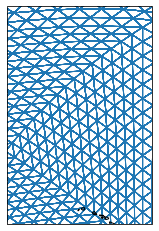

In [19]:
figax=hello_plot(m2_indices,show=False)
figax.ax.set_extent([-170,-150,20,50])
plt.show()

In [18]:
figax.ax.set_extent([-170,-150,20,50])
plt.show()

In [97]:
class merra2_sidecar(object):
    def __init__(self,cover_resolution = 0):
        self.nlat = 361
        self.nlon = 576
        self.dlat = 0.5 # or 180.0/(nlat-1)
        self.dlon = 5.0/8.0 # or 360.0/(nlon)
        self.lat1d = self.dlat*np.arange(self.nlat)-90.0
        self.lon1d = self.dlon*np.arange(self.nlon)-180.0
        self.dLatkm = self.dlat * gd.re_km/gd.deg_per_rad
        self.dLonkm  = self.dlon * gd.re_km/gd.deg_per_rad
        self.lat,self.lon = np.meshgrid(self.lat1d,self.lon1d)
        self.lat_flat     = self.lat.flatten()
        self.lon_flat     = self.lon.flatten()
        self.idx_ij       = np.arange(self.lat_flat.size,dtype=np.int64)
        self.resolution   = int(gd.resolution(self.dLonkm*2))
        self.cover_resolution = cover_resolution
        self.index        = ps.from_latlon(self.lat_flat,self.lon_flat,self.resolution)
        di = ps.spatial_increment_from_level(self.cover_resolution)
        self.cover        = [self.cover_resolution+(i*di) for i in range(8*(4**self.cover_resolution))]
        

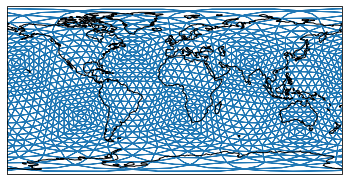

In [104]:
m2_sc=merra2_sidecar(cover_resolution=4)
# m2_sc.cover
hello_plot(m2_sc.cover)

6